In [31]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Carga Datos

In [2]:
tipos = {"fecha": str, "hora": int, "temperatura": float, "humedad": float, "presion": float, "direccion_viento": float, "velocidad_viento": float, "estacion": str}
data = pd.read_csv("clima_bsas.csv",dtype=tipos)
del data["Unnamed: 0"]
data.head(2)

,fecha,hora,temperatura,humedad,presion,direccion_viento,velocidad_viento,estacion
0,01062021,0,16.7,53.0,1012.6,290.0,15.0,AEROPARQUE AERO
1,01062021,1,15.5,66.0,1012.1,320.0,9.0,AEROPARQUE AERO


In [3]:
print(data.shape)
data.dtypes

(87280, 8)


fecha                object
hora                  int64
temperatura         float64
humedad             float64
presion             float64
direccion_viento    float64
velocidad_viento    float64
estacion             object
dtype: object

# Preparación datos

In [4]:
print(data.shape)
datana = data.dropna()
datana.shape

(87280, 8)


(87251, 8)

In [5]:
aero = datana[datana["estacion"] == "AEROPARQUE AERO"].copy()
aero.shape
del aero["estacion"]
aero.dtypes

fecha                object
hora                  int64
temperatura         float64
humedad             float64
presion             float64
direccion_viento    float64
velocidad_viento    float64
dtype: object

In [6]:
aero["fecha"] = pd.to_datetime(aero["fecha"],format="%d%m%Y") #+  pd.to_timedelta(aero.hora, unit='h')
# del aero["hora"]
aero.sort_values(by=["fecha"],inplace=True)
aero.reset_index(inplace=True)
promedios_aero = aero.groupby("fecha").mean().reset_index().sort_values(by="fecha")
del promedios_aero["index"]


In [7]:
aero_prom = aero.join(promedios_aero.set_index("fecha"),on="fecha",rsuffix="_prom")
del aero_prom["hora_prom"]
del aero_prom["index"]
aero_prom.sort_values(by=["fecha","hora"],inplace=True)


In [8]:
promedios_aero["fecha"] = promedios_aero["fecha"] + pd.Timedelta(-1,unit="day")
predictor = aero.join(promedios_aero.set_index("fecha"),on="fecha",rsuffix="_prom_dia_sig")
del predictor["index"]
del predictor["hora_prom_dia_sig"]
predictor.dropna(inplace=True)
predictor.sort_values(by="fecha",inplace=True)
promedios_aero["fecha"] = promedios_aero["fecha"] + pd.Timedelta(1,unit="day")



# Modelos predecir temperatura

In [9]:
predictor.columns

Index(['fecha', 'hora', 'temperatura', 'humedad', 'presion',
       'direccion_viento', 'velocidad_viento', 'temperatura_prom_dia_sig',
       'humedad_prom_dia_sig', 'presion_prom_dia_sig',
       'direccion_viento_prom_dia_sig', 'velocidad_viento_prom_dia_sig'],
      dtype='object')

In [49]:
x = []
y = []
for grupo,df in predictor.groupby("fecha"):
    # Por ahora no voy a pasar fecha
    x.append((grupo,df[['hora', 'temperatura', 'humedad', 'presion','direccion_viento', 'velocidad_viento']].to_numpy().flatten()))
    if len(x[-1][1]) != 144:
        x.pop()
        continue
    y.append(df.temperatura_prom_dia_sig.iloc[0])
        
assert(len(y) == len(x))

In [54]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.10)
x_graf = list(map(lambda x: x[0], x_test))
x_test = list(map(lambda x: x[1], x_test))
x_train = list(map(lambda x: x[1], x_train))

In [55]:
import sklearn.tree
from sklearn.tree import DecisionTreeRegressor

arbol = DecisionTreeRegressor(max_depth=5)
arbol.fit(x_train, y_train)
arbol.score(x_test,y_test)

0.7868024524627784

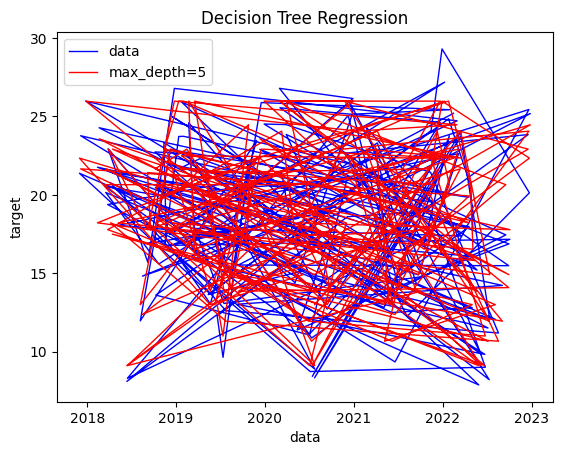

In [67]:
# Plot the results
plt.figure()
plt.plot(x_graf, y_test, c="blue", label="data",linewidth=1)
plt.plot(x_graf, arbol.predict(x_test), color="red", label="max_depth=5", linewidth=1)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [26]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(x_train, y_train)
knn.score(x_test,y_test)

0.19419425676122215